In [6]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import pywt
from scipy.optimize import fsolve
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.15)

In [7]:
base_path = os.path.dirname(os.getcwd())
signal = np.load(os.path.join(base_path, 'single_elm_event.npy'))
signal.shape

(5797, 64)

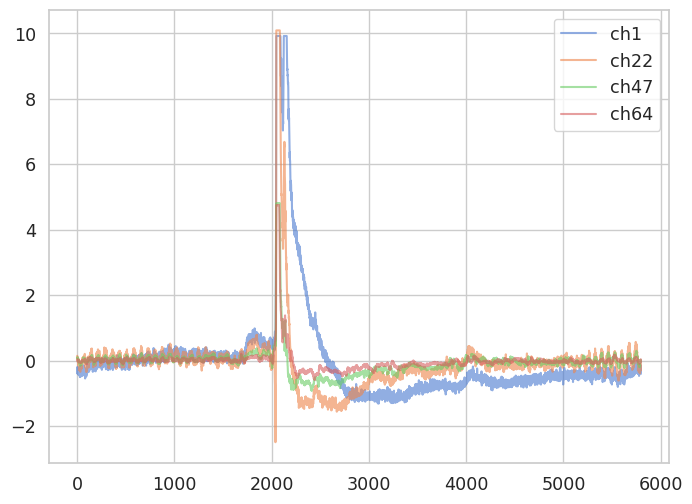

In [8]:
signal_ch1 = signal[:, 0]
signal_ch22 = signal[:, 21]
signal_ch47 = signal[:, 46]
signal_ch64 = signal[:, -1]

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(signal_ch1, alpha=0.6, label='ch1')
ax.plot(signal_ch22, alpha=0.6, label='ch22')
ax.plot(signal_ch47, alpha=0.6, label='ch47')
ax.plot(signal_ch64, alpha=0.6, label='ch64')
ax.legend()
plt.show()

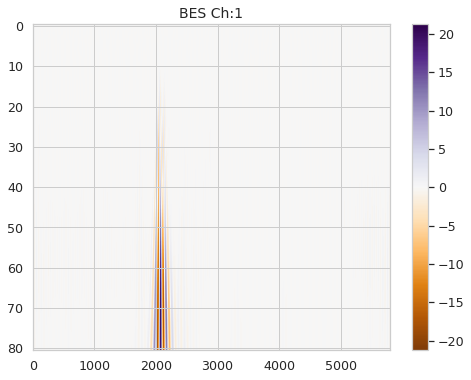

In [9]:
# apply wavelet transforms using pywt
widths = np.arange(1, 82)
coeffs, freqs = pywt.cwt(signal_ch1, widths, 'morl')
# coeffs_squared = np.log(coeffs**2)

plt.figure(figsize=(8, 6))
plt.imshow(
    coeffs,
    cmap="PuOr",
    aspect="auto",
    vmax=abs(coeffs).max(),
    vmin=-abs(coeffs).max(),
)
plt.colorbar()
plt.title('BES Ch:1', fontsize=14);

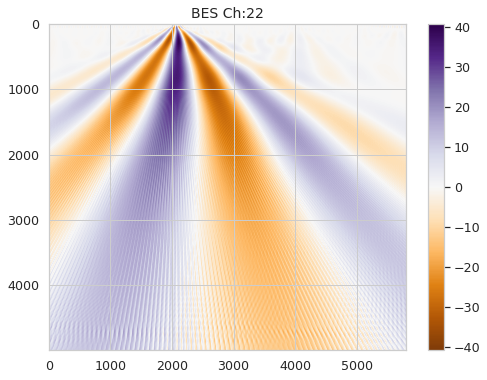

In [10]:
widths = np.arange(1, 5000)
coeffs, freqs = pywt.cwt(signal_ch22, widths, 'morl')

plt.figure(figsize=(8, 6))
plt.imshow(
    coeffs,
    cmap="PuOr",
    aspect="auto",
    vmax=abs(coeffs).max(),
    vmin=-abs(coeffs).max(),
    label='Ch22'
)
plt.colorbar()
plt.title('BES Ch:22', fontsize=14);

(256, 5797)


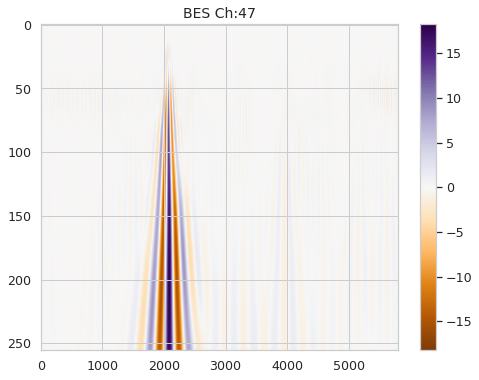

In [11]:
# apply wavelet transforms using pywt
widths = np.arange(1, 257)
coeffs, freqs = pywt.cwt(signal_ch47, widths, 'morl')
print(coeffs.shape)
plt.figure(figsize=(8, 6))
plt.imshow(
    coeffs,
    cmap="PuOr",
    aspect="auto",
    vmax=abs(coeffs).max(),
    vmin=-abs(coeffs).max(),
)
plt.colorbar()
plt.title('BES Ch:47', fontsize=14);

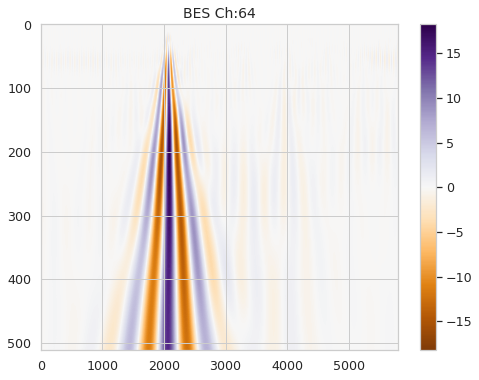

In [12]:
# apply wavelet transforms using pywt
widths = np.arange(1, 513)
coeffs, freqs = pywt.cwt(signal_ch47, widths, 'morl')

plt.figure(figsize=(8, 6))
plt.imshow(
    coeffs,
    cmap="PuOr",
    aspect="auto",
    vmax=abs(coeffs).max(),
    vmin=-abs(coeffs).max(),
)
plt.colorbar()
plt.title('BES Ch:64', fontsize=14);

In [13]:
# apply wavelet transforms using pywt
widths = np.arange(1, 1025)
coeffs, freqs = pywt.cwt(signal, widths, 'morl', axis=0)

coeffs.shape

(1024, 5797, 64)

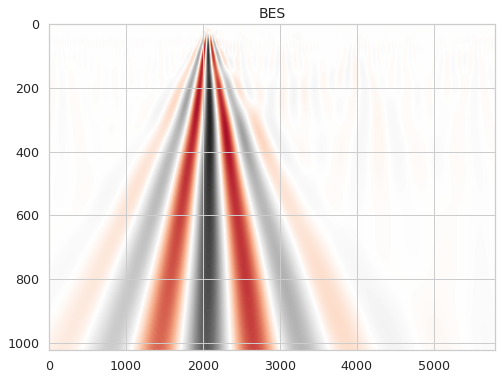

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(
    coeffs[:, :, -1],
    cmap="RdGy",
    aspect="auto",
    vmax=abs(coeffs[:, :, -1]).max(),
    vmin=-abs(coeffs[:, :, -1]).max(),
)
plt.title('BES', fontsize=14);

In [ ]:
# Following class implements Morlet wavelet
class Morlet(object):
    def __init__(self, w0=6):
        self.w0 = w0
        if w0 == 6:
            self.C_d = 0.776
    
    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w**2))
        
        output *= np.exp(-0.5 * (x**2)) * np.pi**(-0.25)

        return output


class CWT(nn.Module):
    def __init__(
        self, 
        dj=0.0625, 
        dt=1/2048, 
        wavelet=Morlet(), 
        fmin=20, 
        fmax=500, 
        output_format='Magnitude', 
        trainable=False, 
        hop_length=1
    ):
        super().__init__()
        self.wavelet = wavelet
        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable
        self.stride = (1, hop_length)
        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None
        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        if self.signal_length is None:
            raise ValueError('Please specify signal length before computing optimal scales')
        
        J = int(
            (1/self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2**(self.dj * np.arange(0, J+1))

        # TODO: remove high and low frequencies

        return scales
    
    def compute_minimum_scale(self):
        dt = self.dt

        def __solver(s):
            return self.wavelet.fourier_periods(s) - 2 * dt
        
        return fsolve(__solver, 1)[0]
